In [1]:
%load_ext autoreload
%autoreload 2

import sys
import ujson
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from bigbio.dataloader import BigBioConfigHelpers
from tqdm import tqdm, trange

sys.path.insert(1, '..')
from bigbio_utils import dataset_to_df, metamap_text_to_candidates, resolve_abbreviation
from bigbio_utils import dataset_names, dataset_to_pretty_name


conhelps = BigBioConfigHelpers()


In [2]:
def recall_at_k(df, k=1):
    '''
    Calculate recall@k for a dataframe of mentions with ordered candidates
    '''
    df[f'matched_at_k'] = df[['cuis','candidates']].apply(lambda x: any([y in x[0] for y in x[1][:k]]), axis=1)
    return df['matched_at_k'].mean()


In [4]:
# Settings to keep track of
resolve_abbrevs = False
dataset = 'medmentions_full'
output_path = '../metamap/medmentions/mm_output_2017AA_NLM_strict.csv'

# Load and deduplicate BigBio dataset
data = conhelps.for_config_name(f"{dataset}_bigbio_kb").load_dataset()
df = dataset_to_df(data)
df['cuis'] = df['db_ids']

# # Keep track of datasets and their locations
# dataset_to_output_path = {
#     'bc5cdr':'',
#     'medmentions_full':'../metamap/medmentions/mm_output_2017AA_NLM_strict.csv',
#     'medmentions_st21pv':'',
#     'gnormplus':'',
#     'nlmchem':'../metamap/nlmchem/nlmchem_22AA_strict_wsd.json.csv',
#     'nlm_gene':'',
#     'ncbi_disease': '../metamap/ncbi_disease/ncbi_disease_22AA_strict.csv',
# }

abbreviations = ujson.load(open('../data/abbreviations.json'))



metamap_output = pd.read_csv(output_path, na_filter=False)

Reusing dataset medmentions (/Users/davidkartchner/.cache/huggingface/datasets/medmentions/medmentions_full_bigbio_kb/1.0.0/3fc6b8a3681d540ae6c7497c238636b543b90764247b5ff3642d243474000794)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


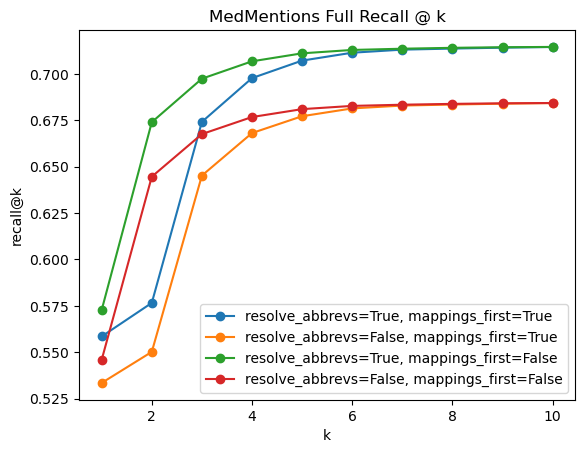

In [7]:
# Load data and get candidates for each entr
# for dataset in tqdm(dataset_names):
    # output_path = dataset_to_output_path[dataset]
    # if output_path == '':
    #     continue

    # metamap_output = pd.read_csv(output_path, na_filter=False)
    # text2candidates = metamap_text_to_candidates(metamap_output)

# # Load and deduplicate BigBio dataset
# data = conhelps.for_config_name(f"{dataset}_bigbio_kb").load_dataset()
# df = dataset_to_df(data)
# df['cuis'] = df['db_ids']

# Determine whether candidates or mapptings are better
for mappings_first in [True, False]:
    if mappings_first:
        cols = ["text", "mapping_cui_list", "candidate_cui_list"]
    else:
        cols = ["text", "candidate_cui_list", "mapping_cui_list",]

    # Determine gains from resolving abbreviations
    for resolve_abbrevs in [True, False]:
        
        # Create mapping from text to candidates for MedMentions
        text2candidates = defaultdict(list)

        for row in metamap_output[cols].values:
            text = row[0]
            candidates = eval(row[1]) + eval(row[2])
            # TODO: Need to account for correct database for 
            candidates = ["UMLS:" + x for x in candidates]
            text2candidates[text] = candidates

        # Map candidates for each mention
        if resolve_abbrevs:
            df['deabbreviated_text'] = df[['document_id','text']].apply(lambda x: resolve_abbreviation(document_id=x[0], 
                                                                                                       text=x[1], 
                                                                                                       abbreviations_dict=abbreviations), axis=1)
            df['candidates'] = df['deabbreviated_text'].map(text2candidates)
        else:
            df['candidates'] = df['text'].map(text2candidates)

        # Calculate recall@k and plot
        recall_vals = [recall_at_k(df, k=k) for k in trange(1,11)]

        # plt.plot(range(1,11), recall_vals, label=dataset_to_pretty_name[dataset], marker='o')
        plt.plot(range(1,11), recall_vals, label=f"resolve_abbrevs={resolve_abbrevs}, mappings_first={mappings_first}", marker='o')


plt.title(f"{dataset_to_pretty_name[dataset]} Recall @ k")
plt.xlabel('k')
plt.ylabel('recall@k')
plt.legend()
plt.show()

    